### Importing Libraries

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,matplotlib,sklearn,pandas,torch

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.27.0

numpy     : 1.26.4
scipy     : 1.13.1
matplotlib: 3.9.2
sklearn   : 1.5.2
pandas    : 2.2.2
torch     : 2.3.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary  # For model summary
import time
import torch.nn as nn


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Function to set random seeds
def set_random_seed(seed):
    # Set random seed for PyTorch CPU and GPU
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    # Set random seed for NumPy (if used)
    np.random.seed(seed)
    # For Python's random module (if needed)


    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import random
    random.seed(seed)

In [4]:
set_random_seed(42)

In [5]:
random_seed = 42
batch_size = 16
num_epochs = 10
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
import torch

print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available devices: {torch.cuda.device_count()}")
# print(f"Device name: {torch.cuda.get_device_name(0)}")
torch.cuda.empty_cache()


False
Available devices: 0


### Loading Data

In [7]:
# Define the transformations (resize and conversion to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor(),           # Convert to tensor for processing
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.215])

])

# Set the paths for the training and testing directories
output_dir_base = './reduced_data'
train_dir = os.path.join(output_dir_base, 'train')
test_dir = os.path.join(output_dir_base, 'test')

# Ensure the directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Training or testing directory not found.")

# Load the training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create the training DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print("Numer of training samples: ", len(train_loader))
# Create the testing DataLoader
test_loader = DataLoader(test_dataset, batch_size= 40, shuffle=False)

# Print the size of training and testing datasets
print(f'Total training samples: {len(train_dataset)}')
print(f'Total testing samples: {len(test_dataset)}')

# Print class labels (to confirm that subdirectories are used as class labels)
print(f'Class labels: {train_dataset.classes}')

# Example: Print the number of batches in each DataLoader
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of testing batches: {len(test_loader)}')

# Verify class-to-index mapping
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

Numer of training samples:  10
Total training samples: 160
Total testing samples: 40
Class labels: ['sparrow', 'swan']
Number of training batches: 10
Number of testing batches: 1
{'sparrow': 0, 'swan': 1}
{'sparrow': 0, 'swan': 1}


In [8]:
# count numbers for each class
class_counts = {}
for images, labels in train_loader:
    for label in labels:
        label = label.item()
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

print(class_counts)

{1: 80, 0: 80}


### VGG 1 Block

In [9]:
class VGG1Block(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG1Block, self).__init__()
        
        # A single convolutional layer followed by max pooling
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with a 2x2 kernel
        )
        
        # Fully connected layers
        # After the Conv2d + MaxPool2d, the size will be reduced by a factor of 2 (224 -> 112)
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 112 * 112, 128),  # Adjust size for 112x112 after max pooling
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
        
    #     # Apply Kaiming uniform initialization
    #     self._initialize_weights()

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    #             torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
    #             if m.bias is not None:
    #                 m.bias.detach().zero_()

    def forward(self, x):
        x = self.block_1(x)
        x = self.fc_block(x)
        return x

# Create the model
model = VGG1Block()
model.to(device)
summary(model, (3, 224, 224))  # Input size of 224x224x3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
           Flatten-4               [-1, 401408]               0
            Linear-5                  [-1, 128]      51,380,352
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
           Sigmoid-8                    [-1, 1]               0
Total params: 51,381,377
Trainable params: 51,381,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 30.63
Params size (MB): 196.00
Estimated Total Size (MB): 227.21
----------------------------------------------------------------


### Helper functions

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
import shutil
import os

def clear_runs_directory(model_name):
    runs_dir = "runs"
    # Define subdirectories to clear
    subdirs = [f"{model_name}_Images", f"{model_name}_Test", f"{model_name}_Train"]
    
    for subdir in subdirs:
        model_runs_dir = os.path.join(runs_dir, subdir)
        
        if os.path.exists(model_runs_dir):
            shutil.rmtree(model_runs_dir)  # Deletes the specific subdirectory
            print(f"Cleared subdirectory: {model_runs_dir}")
        else:
            print(f"No subdirectory found: {model_runs_dir}")

In [11]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, batch_size=16, learning_rate=1e-4, model_name='VGG'):
    
    set_random_seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model_name = model_name

    clear_runs_directory(model_name)

    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    writer_train = SummaryWriter(f"runs/{model_name}_Train")
    writer_test = SummaryWriter(f"runs/{model_name}_Test")

    # Log model graph
    images, _ = next(iter(train_loader))
    writer_train.add_graph(model, images.to(device))

    # Initialize tracking variables
    step_train, step_test = 0, 0
    total_training_time = 0
    epoch_train_losses, epoch_train_accuracies, epoch_test_accuracies = [], [], []



    # Training and evaluation loop
    for epoch in range(num_epochs):
        model.train()
        iter_train_losses, iter_train_accuracies = [], []
        iter_test_losses, iter_test_accuracies = [], []

        total_time = 0
        total_testing_time =0

        start_time = time.time()

        for batch_idx, (data, targets) in enumerate(train_loader):
            
            # Move data to the device
            data, targets = data.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32).unsqueeze(1)

            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            iter_train_losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Training accuracy
            predictions = (scores > 0.5).float()
            correct = (predictions == targets).sum().item()
            train_accuracy = correct / data.shape[0]
            iter_train_accuracies.append(train_accuracy)

            # Log to TensorBoard for training
            writer_train.add_scalar("Loss/train", loss.item(), global_step=step_train)  # Log train loss
            writer_train.add_scalar("Accuracy/train", train_accuracy, global_step=step_train)
            step_train += 1

            start_test_time = time.time()
            
            # Test phase
            model.eval()
            with torch.no_grad():
                for data, targets in test_loader:
                    data, targets = data.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32).unsqueeze(1)

                    # Forward pass
                    scores = model(data)
                    loss = criterion(scores, targets)
                    iter_test_losses.append(loss.item())

                    # Test accuracy
                    predictions = (scores > 0.5).float()
                    correct = (predictions == targets).sum().item()
                    test_accuracy = correct / data.shape[0]
                    iter_test_accuracies.append(test_accuracy)

                    # Log to TensorBoard for testing
                    writer_test.add_scalar("Loss/test", loss.item(), global_step=step_test)  # Log test loss
                    writer_test.add_scalar("Accuracy/test", test_accuracy, global_step=step_test)
                    step_test += 1

            end_test_time = time.time()
            total_testing_time+= end_test_time - start_test_time

            #set model back to training mode
            model.train()

        end_time = time.time()
        total_time = end_time - start_time

        total_training_time = total_time - total_testing_time
        
        # Calculate and print the epoch metrics
        avg_train_loss = sum(iter_train_losses) / len(iter_train_losses)
        avg_train_acc = sum(iter_train_accuracies) / len(iter_train_accuracies)
        avg_test_loss = sum(iter_test_losses) / len(iter_test_losses)
        avg_test_acc = sum(iter_test_accuracies) / len(iter_test_accuracies)
        
        print(f"\nEpoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {avg_train_acc:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, "
              f"Test Accuracy: {avg_test_acc:.4f}")

        epoch_train_losses.append(avg_train_loss)
        epoch_train_accuracies.append(avg_train_acc)
        epoch_test_accuracies.append(avg_test_acc)

    print(f"\n------------\nTotal Training Time: {total_training_time:.2f} seconds\n-------------\n")
    print(f"\n------------\nTotal Testing Time: {total_testing_time:.2f} seconds\n-------------\n")

    # Close the writers
    writer_train.close()
    writer_test.close()

    return epoch_train_losses, epoch_train_accuracies, epoch_test_accuracies


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot training loss and accuracy
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Testing Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_test_predictions_grid(model, test_loader, num_images=40, grid_size=(5, 8), device='cpu', writer=None):
    model.eval()
    images, true_labels, predicted_labels, incorrect_indices = [], [], [], []

    # Mean and standard deviation values used for normalization
    mean = np.array([0.485, 0.456, 0.406])  # Example: ImageNet mean
    std = np.array([0.229, 0.224, 0.215])   # Example: ImageNet std

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            if len(images) >= num_images:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy()

            # Store images and labels for visualization
            images.extend(inputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds)

            # Find and store incorrect indices
            for i, (true_label, pred) in enumerate(zip(labels.cpu().numpy(), preds)):
                if true_label != int(pred):
                    incorrect_indices.append(batch_idx * test_loader.batch_size + i)

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels).squeeze().astype(int)
    correct = (true_labels == predicted_labels).sum()
    total = true_labels.shape[0]
    accuracy = correct / total
    print(f"Accuracy on {total} test images: {accuracy:.4f}")

    # Print the indices of incorrectly labeled images
    print("Indices of incorrectly labeled images:", incorrect_indices)

    # Create a figure for the image grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(16, 10))
    fig.suptitle("True and Predicted Labels on Test Images", fontsize=16)

    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            img = images[idx].transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

            # Denormalize the image
            img = img * std + mean  # Reverse the normalization
            img = np.clip(img, 0, 1)  # Ensure pixel values are in the [0, 1] range

            ax.imshow(img)
            ax.axis("off")
            true_label = int(true_labels[idx])
            predicted_label = int(predicted_labels[idx].squeeze())
            ax.set_title(f"True: {true_label} | Pred: {predicted_label}",
                         color="green" if true_label == predicted_label else "red")
        else:
            ax.axis("off")  # Hide any empty subplots

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Log the grid of images to TensorBoard
    writer.add_figure("Test Predictions Grid", fig)

    # Return the true and predicted labels for further evaluation
    return true_labels, predicted_labels, incorrect_indices

# Plot confusion matrix (only local display)
def plot_confusion_matrix(true_labels, predicted_labels, classes, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Cleared subdirectory: runs\VGG1Block_Images
Cleared subdirectory: runs\VGG1Block_Test
Cleared subdirectory: runs\VGG1Block_Train

Epoch [1/10] - Train Loss: 0.6703, Train Accuracy: 0.6250, Test Loss: 0.6366, Test Accuracy: 0.6250

Epoch [2/10] - Train Loss: 0.4248, Train Accuracy: 0.7875, Test Loss: 0.5618, Test Accuracy: 0.7150

Epoch [3/10] - Train Loss: 0.3585, Train Accuracy: 0.8438, Test Loss: 0.5821, Test Accuracy: 0.7175

Epoch [4/10] - Train Loss: 0.2923, Train Accuracy: 0.8875, Test Loss: 0.6373, Test Accuracy: 0.6950

Epoch [5/10] - Train Loss: 0.2245, Train Accuracy: 0.9187, Test Loss: 0.6416, Test Accuracy: 0.6825

Epoch [6/10] - Train Loss: 0.1762, Train Accuracy: 0.9563, Test Loss: 0.6338, Test Accuracy: 0.7250

Epoch [7/10] - Train Loss: 0.1485, Train Accuracy: 0.9812, Test Loss: 0.6727, Test Accuracy: 0.6975

Epoch [8/10] - Train Loss: 0.1265, Train Accuracy: 0.9875, Test Loss: 0.6929, Test Accuracy: 0.6925

Epoch [9/10] - Train Loss: 0.1020, Train Accuracy: 1.0000, Tes

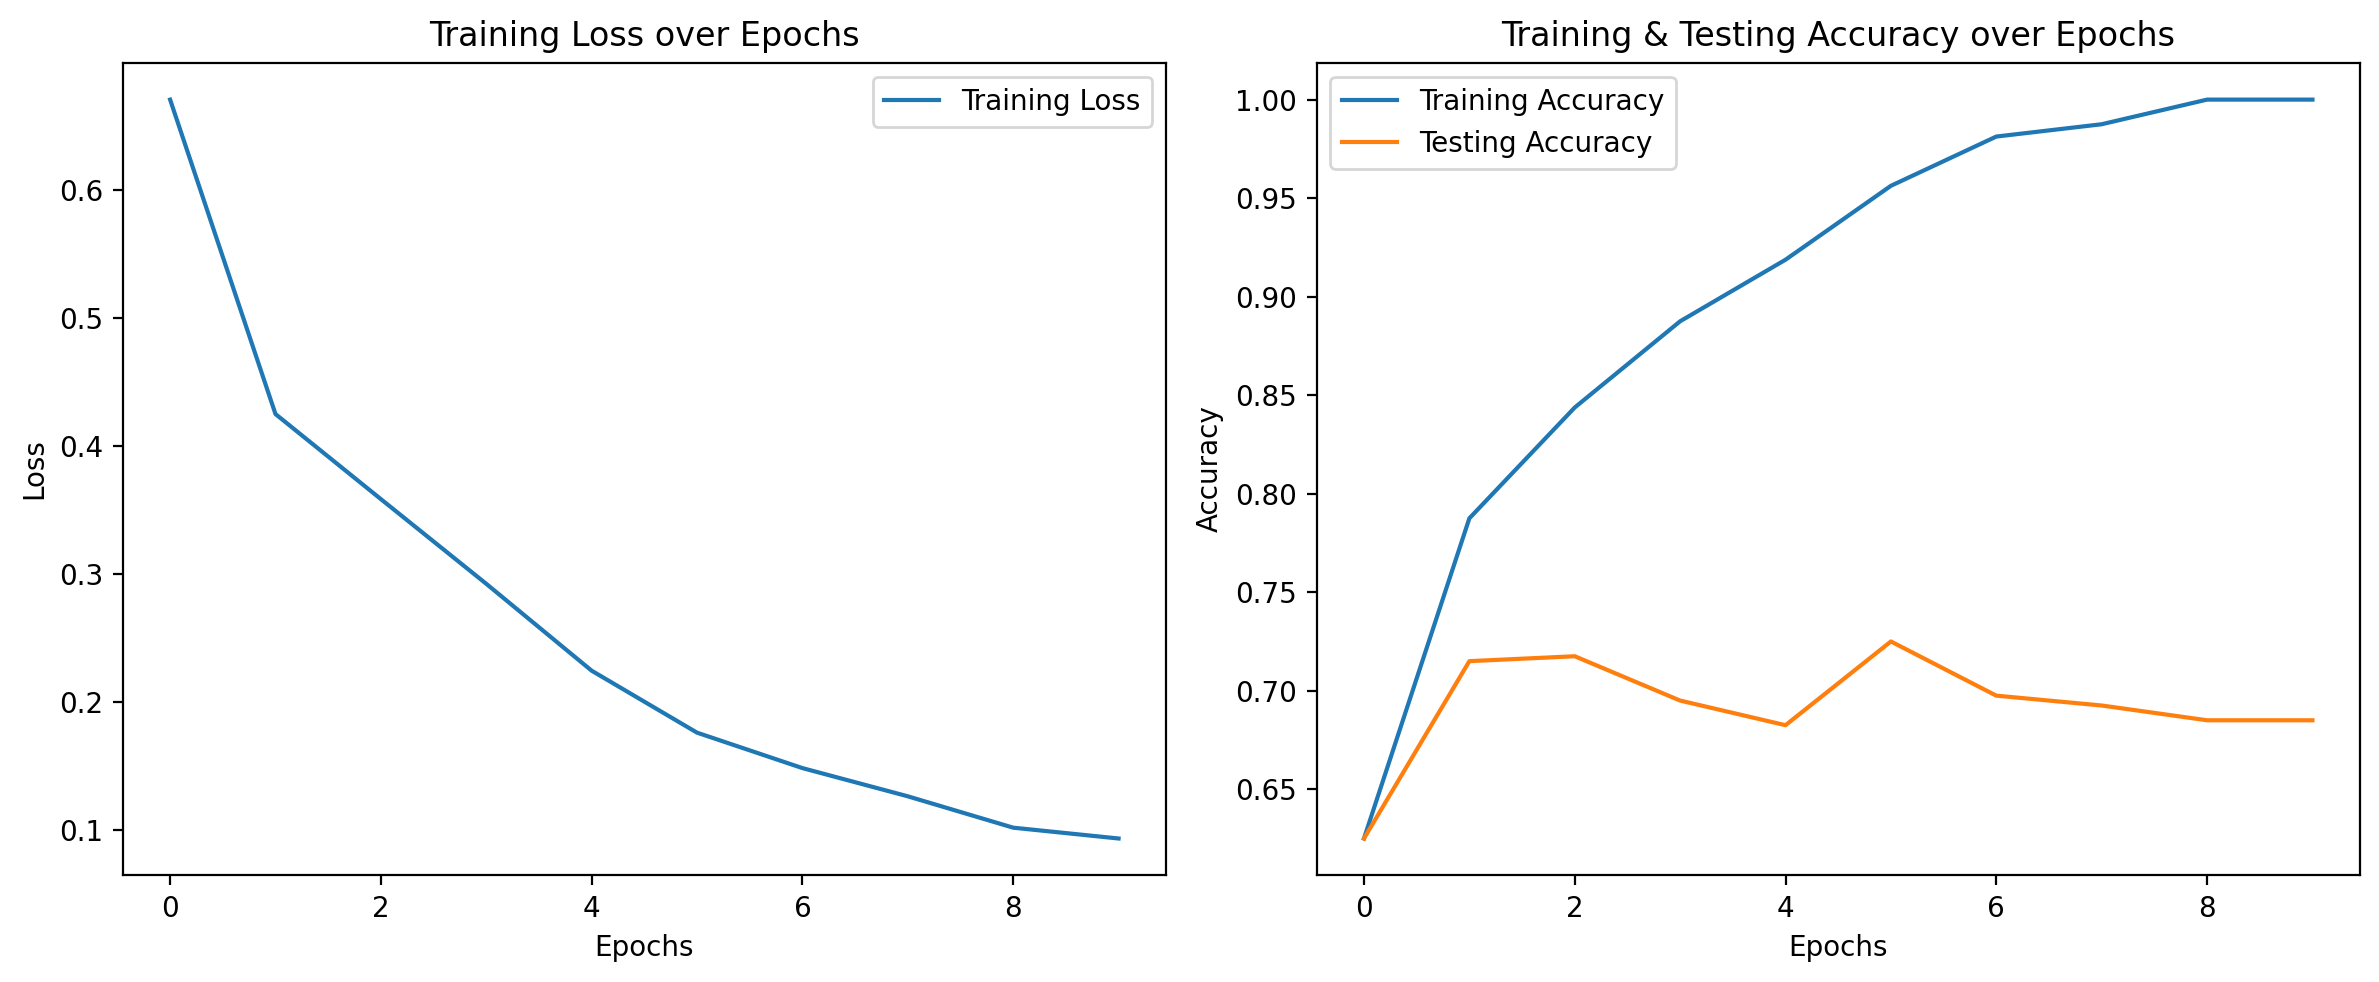

Accuracy on 40 test images: 0.7000
Indices of incorrectly labeled images: [4, 20, 21, 22, 24, 26, 27, 28, 29, 31, 33, 35]


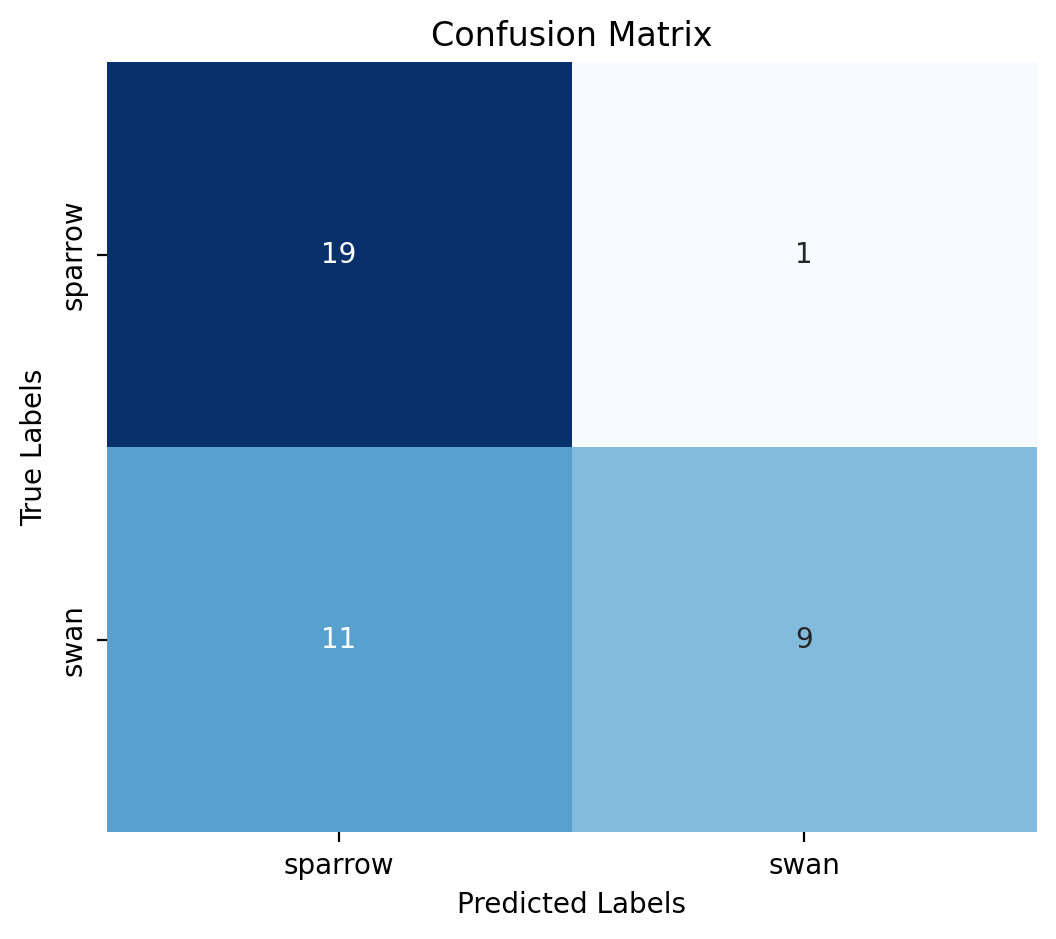

In [13]:
model = VGG1Block()

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, num_epochs= 10, batch_size=16, learning_rate=1e-5,model_name = "VGG1Block"
)

writer_images = SummaryWriter("runs/VGG1Block_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg1 = plot_test_predictions_grid(
    model, test_loader, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["sparrow","swan"])
writer_images.close()

In [14]:
incorrect_indices_vgg1 

[4, 20, 21, 22, 24, 26, 27, 28, 29, 31, 33, 35]

In [15]:
# save the model
torch.save(model.state_dict(), 'models/model_VGG1Block.pth')

### VGG 3 Block

In [16]:
class VGG3Block(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG3Block, self).__init__()
        
        # First Block: Conv2D(32) -> ReLU -> MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv Layer with 32 filters
            nn.ReLU(),  # ReLU Activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
        )
        
        # Second Block: Conv2D(64) -> ReLU -> MaxPool
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv Layer with 64 filters
            nn.ReLU(),  # ReLU Activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
        )
        
        # Third Block: Conv2D(128) -> ReLU -> MaxPool
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv Layer with 128 filters
            nn.ReLU(),  # ReLU Activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 128)  # Flattened size after convolution
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification output
        
    def forward(self, x):
        # Pass input through the convolutional blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Flatten the output from convolutional layers
        x = x.view(x.size(0), -1)
        
        # Pass through the fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)  # ReLU activation in the dense layer
        x = self.fc2(x)
        x = self.sigmoid(x)  # Final sigmoid activation for binary classification
        return x

# Example of using the model
model_3block = VGG3Block(num_classes=1)

# Print the model summary (for input size 224x224x3)
from torchsummary import summary
summary(model_3block, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 128]      12,845,184
           Linear-11                    [-1, 1]             129
          Sigmoid-12                    [-1, 1]               0
Total params: 12,938,561
Trainable params: 12,938,561
Non-trainable params: 0
-------------------------

Cleared subdirectory: runs\VGG3Block_Images
Cleared subdirectory: runs\VGG3Block_Test
Cleared subdirectory: runs\VGG3Block_Train

Epoch [1/10] - Train Loss: 0.6866, Train Accuracy: 0.5125, Test Loss: 0.6861, Test Accuracy: 0.5000

Epoch [2/10] - Train Loss: 0.6411, Train Accuracy: 0.6937, Test Loss: 0.6642, Test Accuracy: 0.5900

Epoch [3/10] - Train Loss: 0.6116, Train Accuracy: 0.6937, Test Loss: 0.6498, Test Accuracy: 0.5925

Epoch [4/10] - Train Loss: 0.5822, Train Accuracy: 0.7375, Test Loss: 0.6402, Test Accuracy: 0.5850

Epoch [5/10] - Train Loss: 0.5551, Train Accuracy: 0.7438, Test Loss: 0.6316, Test Accuracy: 0.6000

Epoch [6/10] - Train Loss: 0.5289, Train Accuracy: 0.7438, Test Loss: 0.6247, Test Accuracy: 0.6250

Epoch [7/10] - Train Loss: 0.5064, Train Accuracy: 0.7750, Test Loss: 0.6189, Test Accuracy: 0.6375

Epoch [8/10] - Train Loss: 0.4832, Train Accuracy: 0.8063, Test Loss: 0.6126, Test Accuracy: 0.6600

Epoch [9/10] - Train Loss: 0.4604, Train Accuracy: 0.8000, Tes

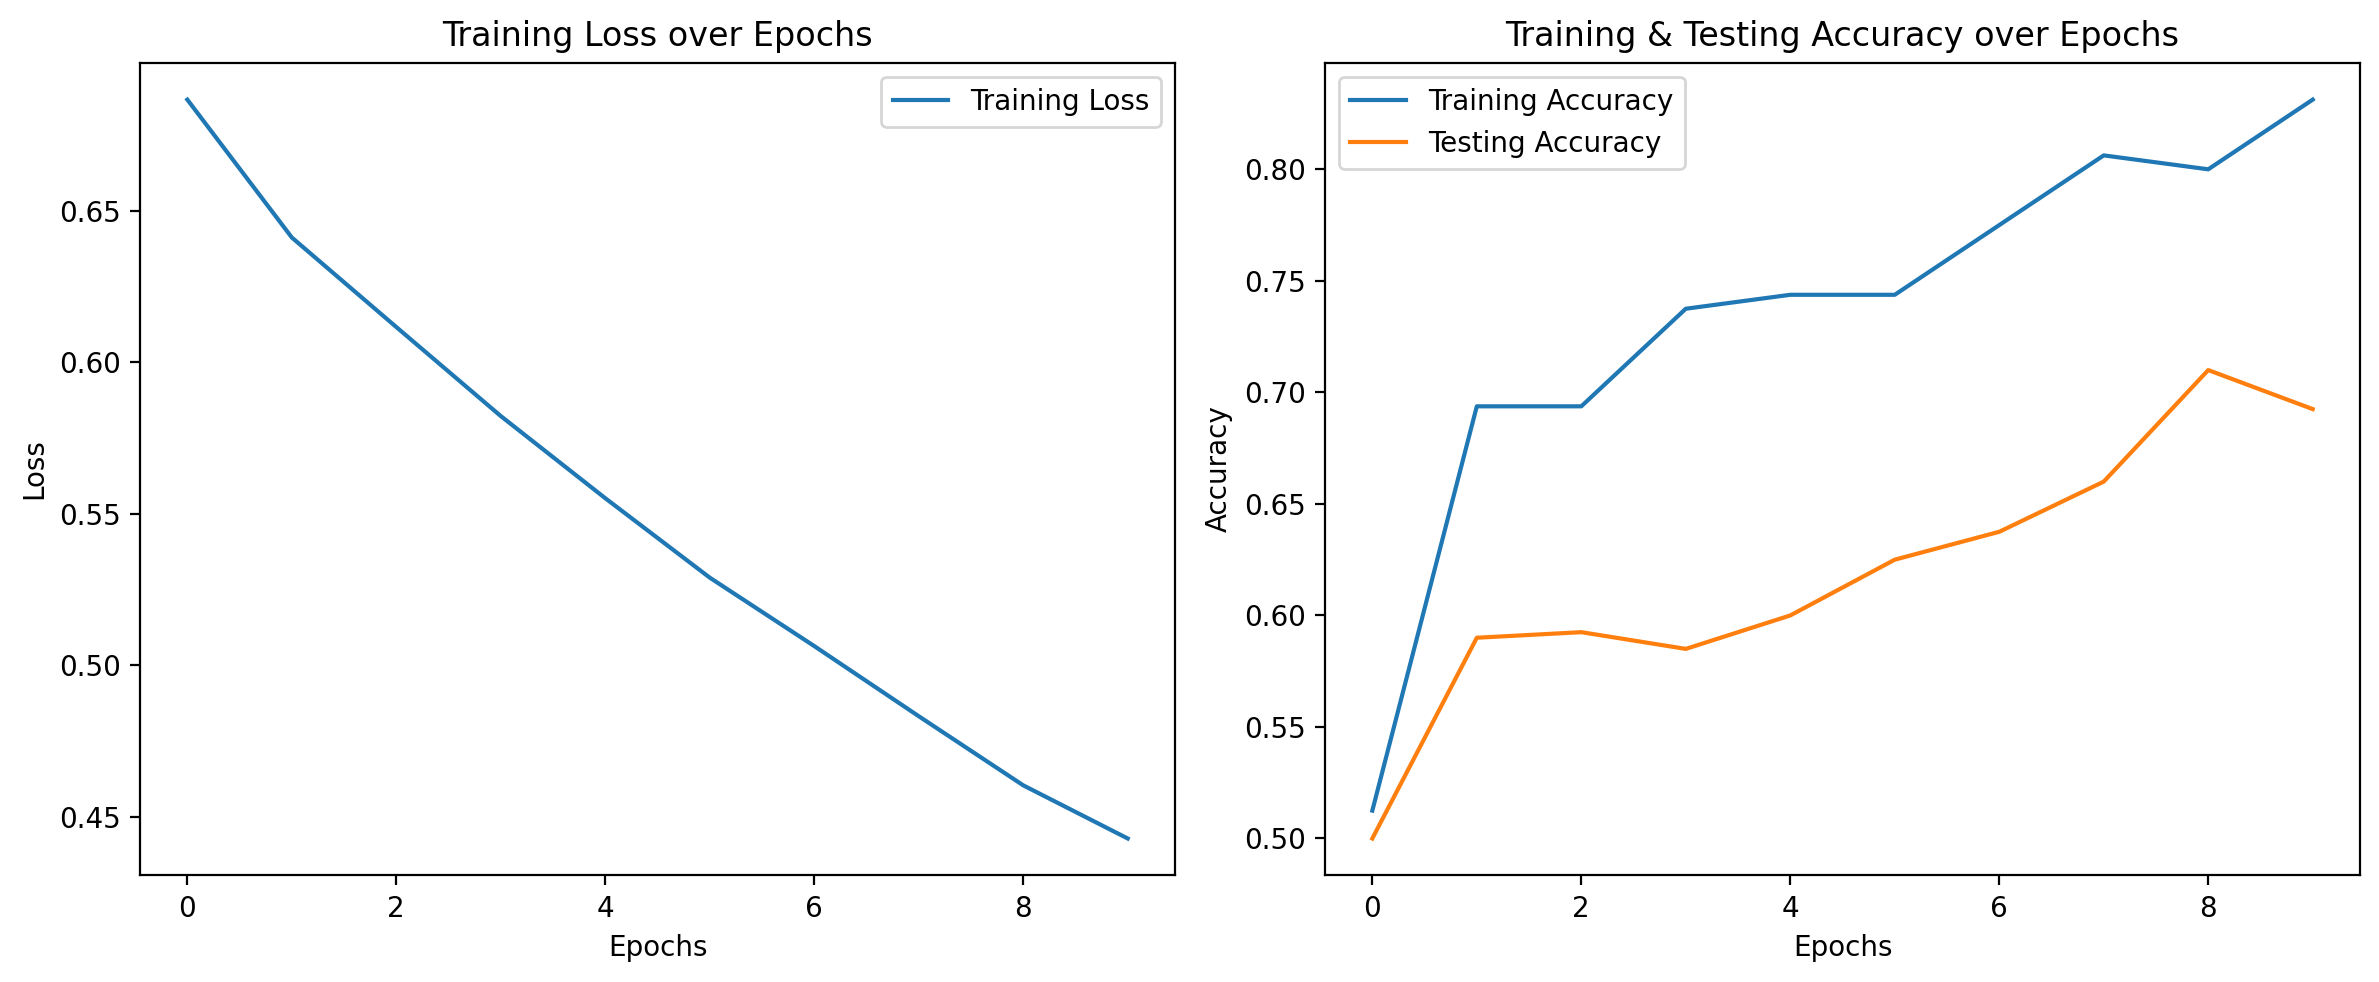

Accuracy on 40 test images: 0.7000
Indices of incorrectly labeled images: [4, 7, 13, 15, 21, 22, 24, 27, 28, 31, 34, 35]


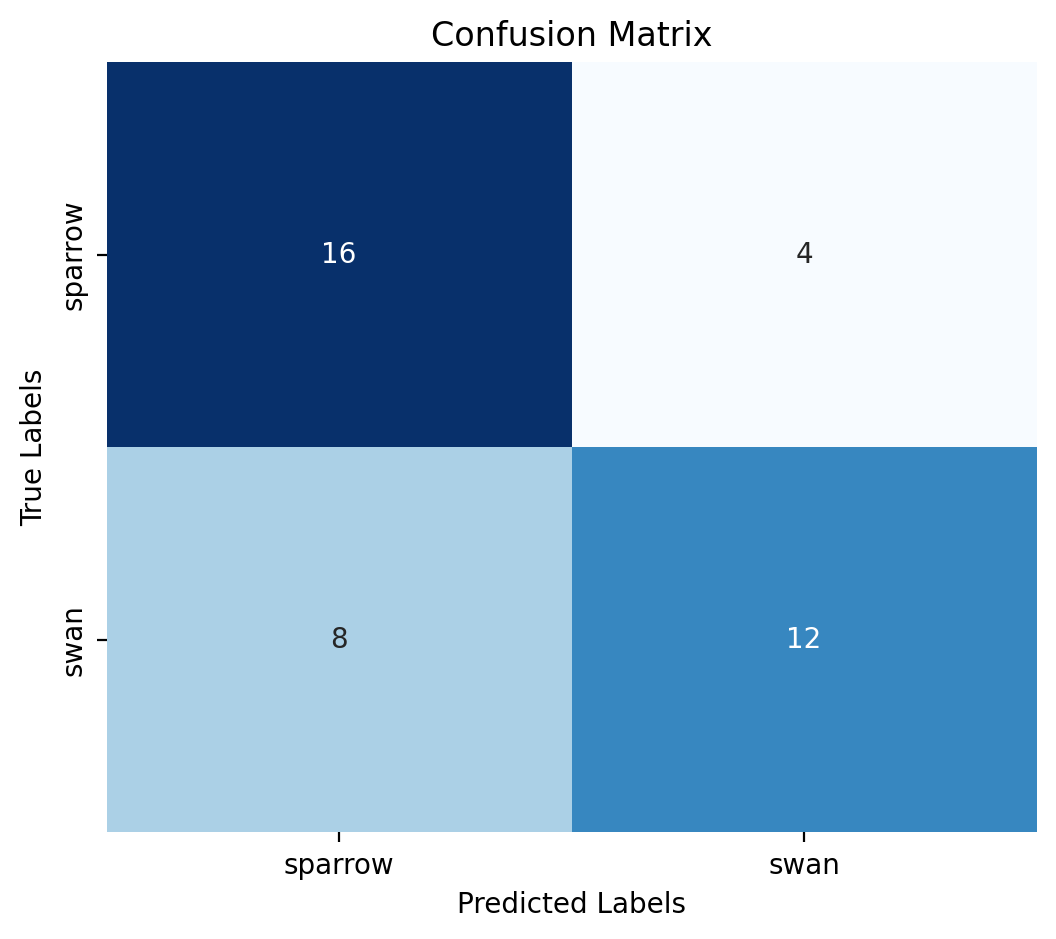

In [17]:
model = VGG3Block()

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, num_epochs= 10, batch_size=16, learning_rate=1e-5,model_name = "VGG3Block"
)

writer_images = SummaryWriter("runs/VGG3Block_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg3  = plot_test_predictions_grid(
    model, test_loader, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["sparrow","swan"])
writer_images.close()

In [18]:
incorrect_indices_vgg3

[4, 7, 13, 15, 21, 22, 24, 27, 28, 31, 34, 35]

In [19]:
torch.save(model.state_dict(), 'models/model_VGG3Block.pth')

### Data Augmentation

In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import os

# Define the transformations (resize, augmentation, and conversion to tensor)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),          # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),    # Random horizontal flip with 50% probability
    transforms.RandomRotation(20),              # Random rotation by 16 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),                      # Convert to tensor for processing
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (for pretrained models)
])

# Set the paths for the training and testing directories
output_dir_base = './reduced_data'
train_dir = os.path.join(output_dir_base, 'train')
test_dir = os.path.join(output_dir_base, 'test')

# Ensure the directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Training or testing directory not found.")

# Load the training dataset with augmentations
train_dataset_aug = datasets.ImageFolder(root=train_dir, transform=transform)

# Load the testing dataset without augmentations (usually no augmentations for test data)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

test_dataset_aug = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Create the training DataLoader
train_loader_aug = DataLoader(train_dataset_aug, batch_size=16, shuffle=True)
print("Number of training samples: ", len(train_loader_aug))

# Create the testing DataLoader
test_loader_aug = DataLoader(test_dataset_aug, batch_size=16, shuffle=False)

# Print the size of training and testing datasets
print(f'Total training samples: {len(train_dataset_aug)}')
print(f'Total testing samples: {len(test_dataset_aug)}')

# Print class labels (to confirm that subdirectories are used as class labels)
print(f'Class labels: {train_dataset_aug.classes}')

# Example: Print the number of batches in each DataLoader
print(f'Number of training batches: {len(train_loader_aug)}')
print(f'Number of testing batches: {len(test_loader_aug)}')

# Verify class-to-index mapping
print(train_dataset_aug.class_to_idx)
print(test_dataset_aug.class_to_idx)


Number of training samples:  10
Total training samples: 160
Total testing samples: 40
Class labels: ['sparrow', 'swan']
Number of training batches: 10
Number of testing batches: 3
{'sparrow': 0, 'swan': 1}
{'sparrow': 0, 'swan': 1}


The augmentation transformations you defined (such as random cropping, flipping, rotation, etc.) are applied on the fly when the images are loaded. This means that the number of images in your train_loader_aug is still the same as the number of images in the train_dir (i.e., no new images are being created in the directory itself).

Cleared subdirectory: runs\VGG3Block_aug_Images
Cleared subdirectory: runs\VGG3Block_aug_Test
Cleared subdirectory: runs\VGG3Block_aug_Train

Epoch [1/10] - Train Loss: 0.6844, Train Accuracy: 0.6375, Test Loss: 0.6846, Test Accuracy: 0.6146

Epoch [2/10] - Train Loss: 0.6631, Train Accuracy: 0.6375, Test Loss: 0.6568, Test Accuracy: 0.6625

Epoch [3/10] - Train Loss: 0.6408, Train Accuracy: 0.7188, Test Loss: 0.6425, Test Accuracy: 0.7333

Epoch [4/10] - Train Loss: 0.6287, Train Accuracy: 0.7188, Test Loss: 0.6154, Test Accuracy: 0.7292

Epoch [5/10] - Train Loss: 0.6191, Train Accuracy: 0.6750, Test Loss: 0.6116, Test Accuracy: 0.7271

Epoch [6/10] - Train Loss: 0.5981, Train Accuracy: 0.7125, Test Loss: 0.5920, Test Accuracy: 0.7292

Epoch [7/10] - Train Loss: 0.5715, Train Accuracy: 0.7688, Test Loss: 0.5853, Test Accuracy: 0.7375

Epoch [8/10] - Train Loss: 0.5786, Train Accuracy: 0.7125, Test Loss: 0.5937, Test Accuracy: 0.6875

Epoch [9/10] - Train Loss: 0.5503, Train Accuracy:

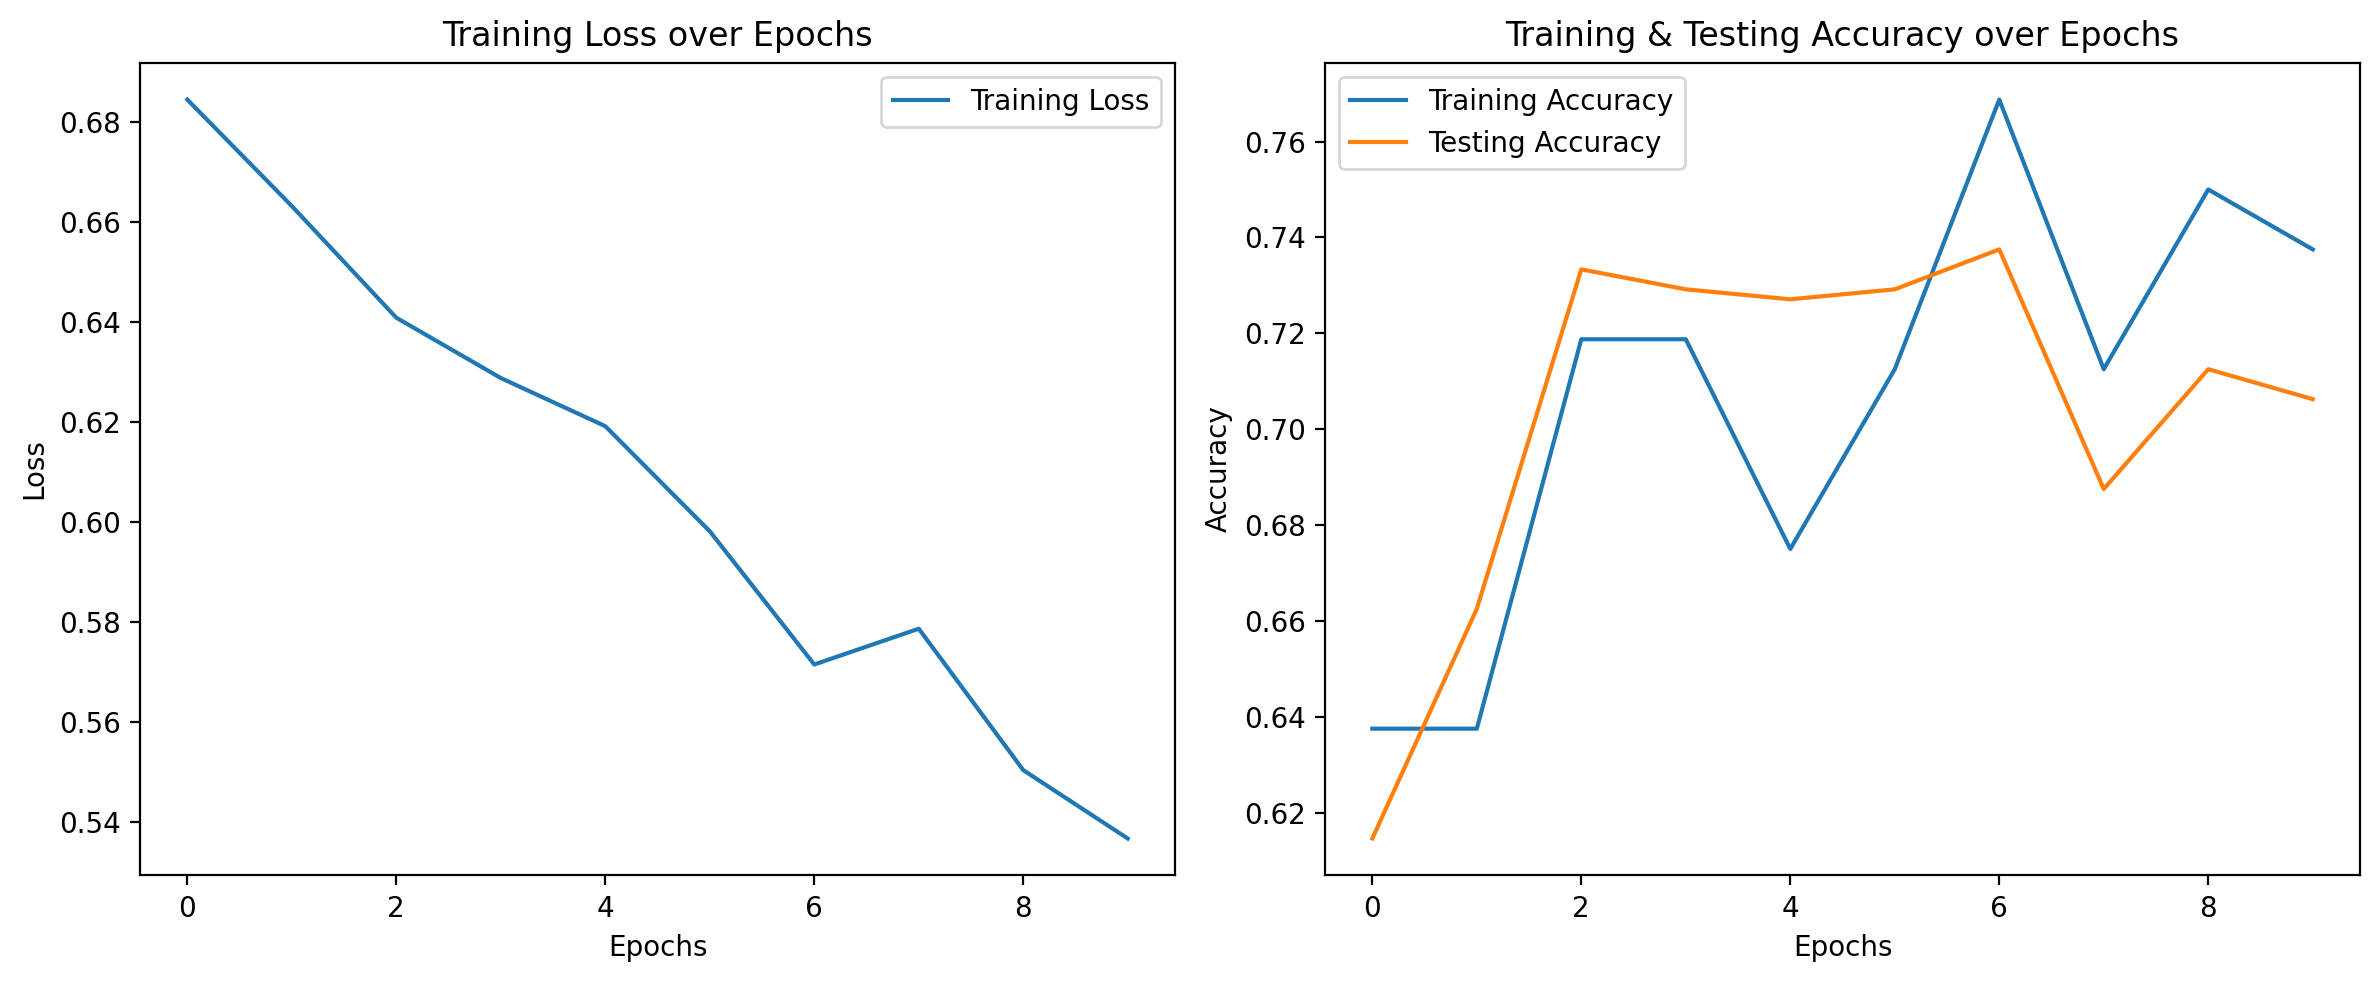

Accuracy on 40 test images: 0.7250
Indices of incorrectly labeled images: [4, 7, 9, 15, 21, 24, 27, 28, 33, 35, 37]


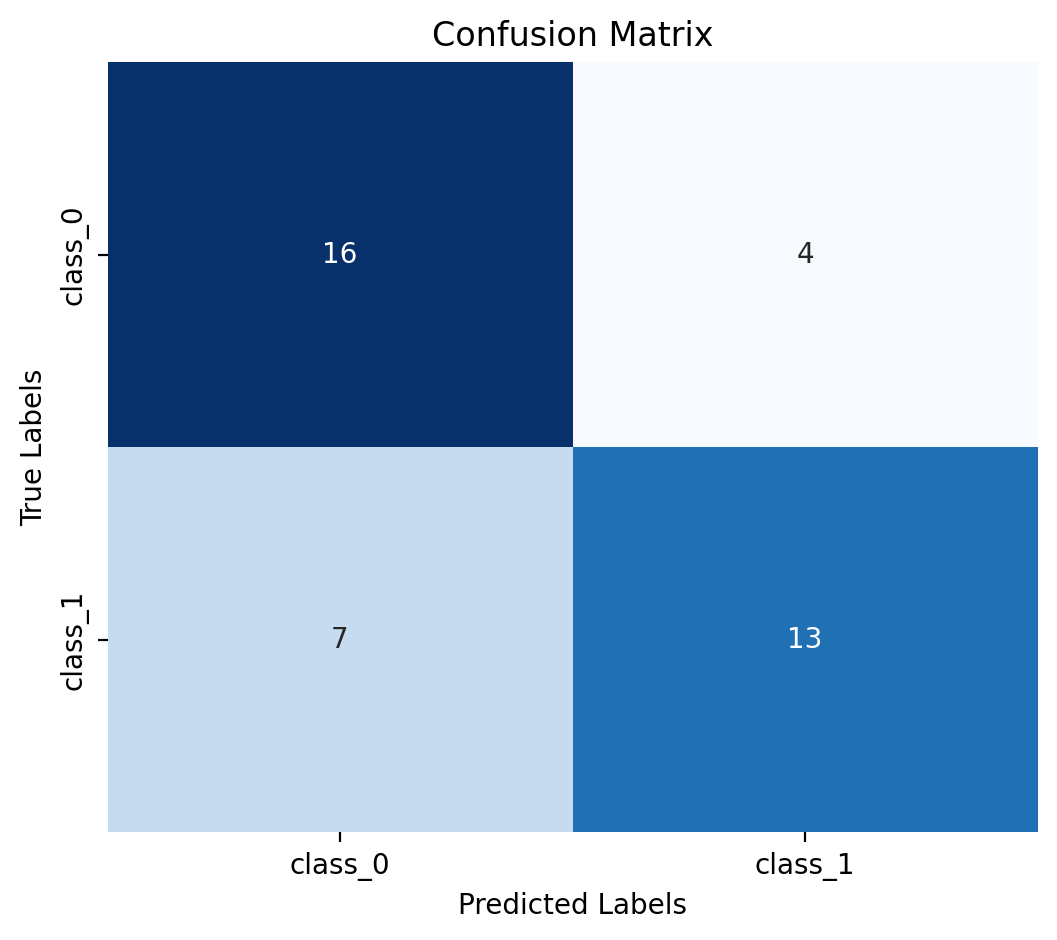

In [32]:
model = VGG3Block()


train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader_aug, test_loader_aug, num_epochs= 10, batch_size=16, learning_rate=1e-5,model_name = 'VGG3Block_aug'
)

writer_images = SummaryWriter("runs/VGG3Block_aug_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg3_aug = plot_test_predictions_grid(
    model, test_loader_aug, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["class_0", "class_1"])
writer_images.close()

In [33]:
# save the model
torch.save(model.state_dict(), 'models/model_VGG3Block_aug.pth')


In [34]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import os

import torchvision.transforms as transforms

# Define the transformations with increased augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),        # Random crop and resize, with a wider scale range
    transforms.RandomHorizontalFlip(p=0.7),                     # Higher probability for horizontal flip
    transforms.RandomVerticalFlip(p=0.3),                       # Add vertical flip with a 30% probability
    transforms.RandomRotation(degrees=30),                      # Increase rotation range to 30 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Increase color jitter range
    transforms.RandomGrayscale(p=0.1),                          # Randomly convert images to grayscale with 10% probability
    transforms.RandomAffine(degrees=0,                          # Apply small translations for added variance
                            translate=(0.1, 0.1),               # Translate images by up to 10%
                            scale=(0.8, 1.2),                   # Allow scaling between 80% and 120%
                            shear=10),                          # Apply shear transformation up to 10 degrees
    transforms.ToTensor(),                                      # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],            # Normalize (for pretrained models)
                         std=[0.229, 0.224, 0.225])
])


# Set the paths for the training and testing directories
output_dir_base = './reduced_data'
train_dir = os.path.join(output_dir_base, 'train')
test_dir = os.path.join(output_dir_base, 'test')

# Ensure the directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Training or testing directory not found.")

# Load the training dataset with augmentations
train_dataset_aug = datasets.ImageFolder(root=train_dir, transform=transform)

# Load the testing dataset without augmentations (usually no augmentations for test data)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])



Cleared subdirectory: runs\VGG3Block_aug2_Images
Cleared subdirectory: runs\VGG3Block_aug2_Test
Cleared subdirectory: runs\VGG3Block_aug2_Train

Epoch [1/10] - Train Loss: 0.6905, Train Accuracy: 0.5250, Test Loss: 0.6938, Test Accuracy: 0.5062

Epoch [2/10] - Train Loss: 0.6788, Train Accuracy: 0.6188, Test Loss: 0.6701, Test Accuracy: 0.6125

Epoch [3/10] - Train Loss: 0.6643, Train Accuracy: 0.6687, Test Loss: 0.6701, Test Accuracy: 0.6458

Epoch [4/10] - Train Loss: 0.6604, Train Accuracy: 0.6625, Test Loss: 0.6461, Test Accuracy: 0.6750

Epoch [5/10] - Train Loss: 0.6561, Train Accuracy: 0.6312, Test Loss: 0.6496, Test Accuracy: 0.6792

Epoch [6/10] - Train Loss: 0.6367, Train Accuracy: 0.6875, Test Loss: 0.6283, Test Accuracy: 0.6813

Epoch [7/10] - Train Loss: 0.6163, Train Accuracy: 0.7375, Test Loss: 0.6189, Test Accuracy: 0.6833

Epoch [8/10] - Train Loss: 0.6216, Train Accuracy: 0.6813, Test Loss: 0.6270, Test Accuracy: 0.6542

Epoch [9/10] - Train Loss: 0.5948, Train Accura

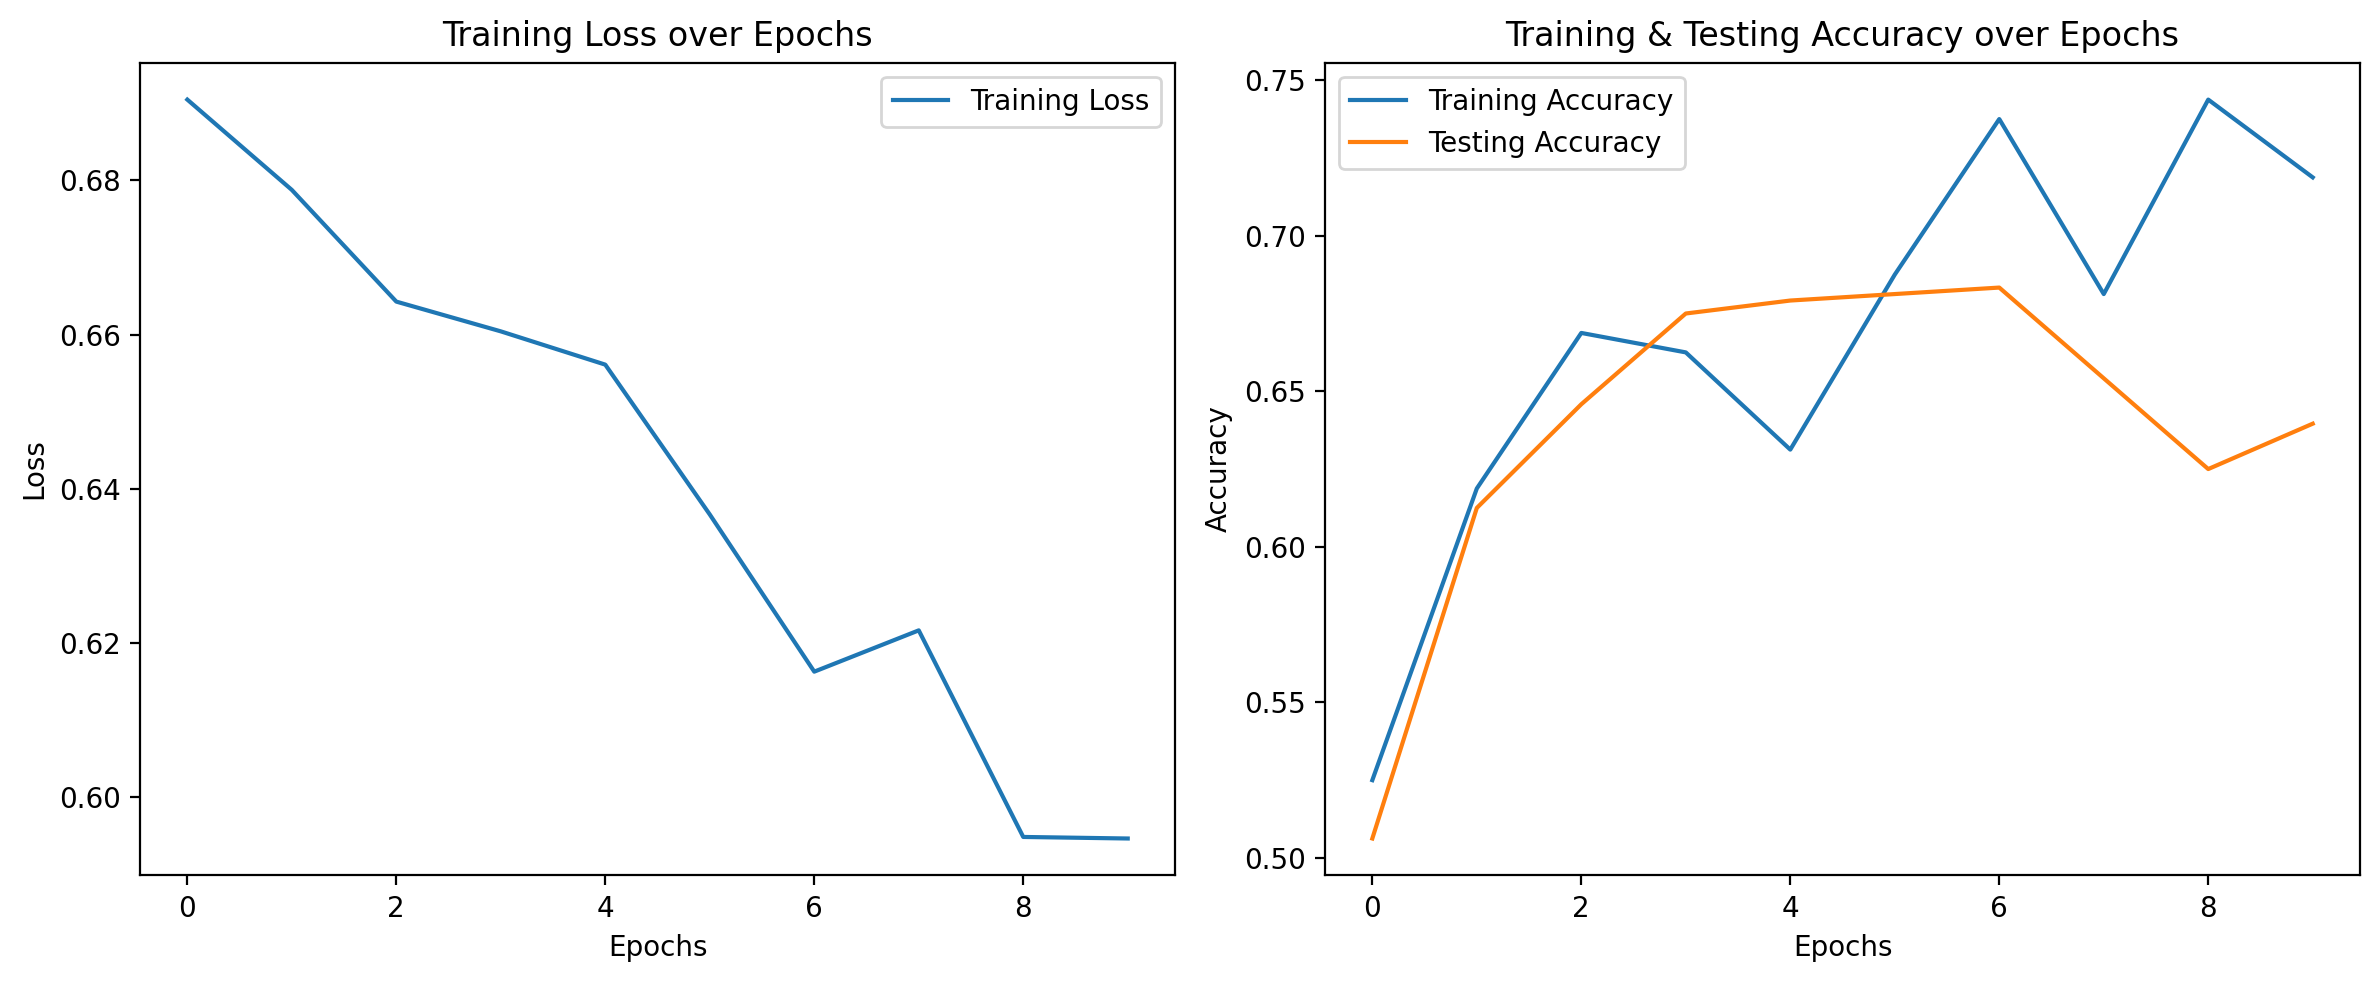

Accuracy on 40 test images: 0.6250
Indices of incorrectly labeled images: [3, 4, 7, 9, 13, 15, 21, 22, 24, 27, 28, 31, 33, 35, 37]


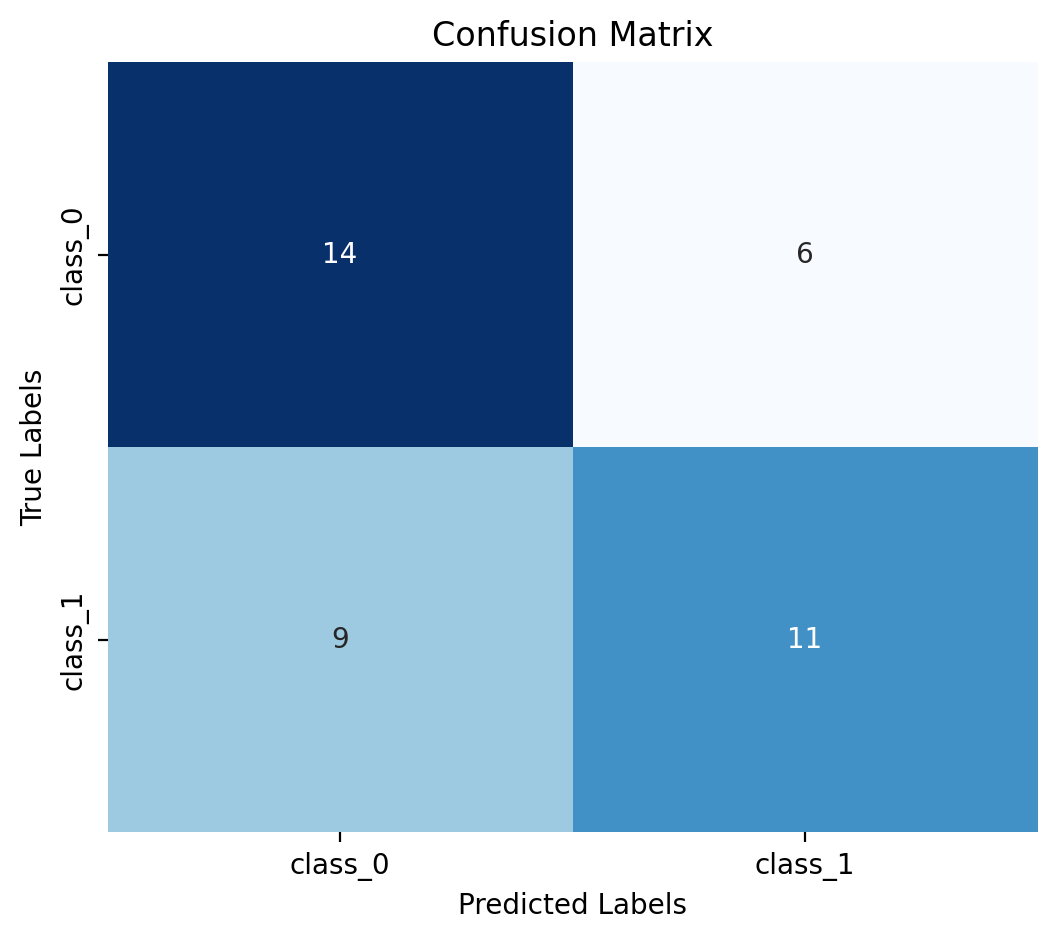

In [41]:
model = VGG3Block()

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader_aug, test_loader_aug, num_epochs= 10, batch_size=16, learning_rate=1e-5,model_name = 'VGG3Block_aug2'
)

writer_images = SummaryWriter("runs/VGG3Block_aug2_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg3_aug2 = plot_test_predictions_grid(
    model, test_loader_aug, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["class_0", "class_1"])
writer_images.close()

In [36]:
incorrect_indices_vgg3_aug2

[3, 4, 7, 9, 13, 15, 21, 22, 24, 27, 28, 31, 33, 35, 37]

In [37]:
## Compare the most incorectly classified images and plot them - (using incorrect_indices_vgg1, incorrect_indices_vgg3, incorrect_indices_vgg3_aug, incorrect_indices_vgg3_aug2)
import matplotlib.pyplot as plt
import numpy as np

print(incorrect_indices_vgg1)
print(incorrect_indices_vgg3)
print(incorrect_indices_vgg3_aug)
print(incorrect_indices_vgg3_aug2)



[4, 20, 21, 22, 24, 26, 27, 28, 29, 31, 33, 35]
[4, 7, 13, 15, 21, 22, 24, 27, 28, 31, 34, 35]
[4, 7, 9, 15, 21, 24, 27, 28, 33, 35, 37]
[3, 4, 7, 9, 13, 15, 21, 22, 24, 27, 28, 31, 33, 35, 37]


In [38]:
# find the common indices
common_indices = set(incorrect_indices_vgg1).intersection(incorrect_indices_vgg3,incorrect_indices_vgg3_aug,incorrect_indices_vgg3_aug2)
common_indices = list(common_indices)
common_indices

[35, 4, 21, 24, 27, 28]

In [39]:
# display the common indices - plot the images

def plot_images(indices, test_loader, grid_size=(2, 5), device='cpu'):
    # denormalize the images (VGG)
    mean = np.array([0.485, 0.456, 0.406])  # Example: ImageNet mean
    std = np.array([0.229, 0.224, 0.215])   # Example: ImageNet std

    # Create a figure for the image grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 8))
    fig.suptitle("Common Incorrectly Classified Images", fontsize=16)

    for idx, ax in enumerate(axes.flat):
        if idx < len(indices):
            data, labels = test_loader.dataset[indices[idx]]
            img = data.cpu().numpy().transpose(1, 2, 0)
            img = img * std + mean

            ax.imshow(img)

            true_label = test_loader.dataset.classes[labels]

            ax.set_title(f"True: {true_label}", color="red")
        else:
            ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

    




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].


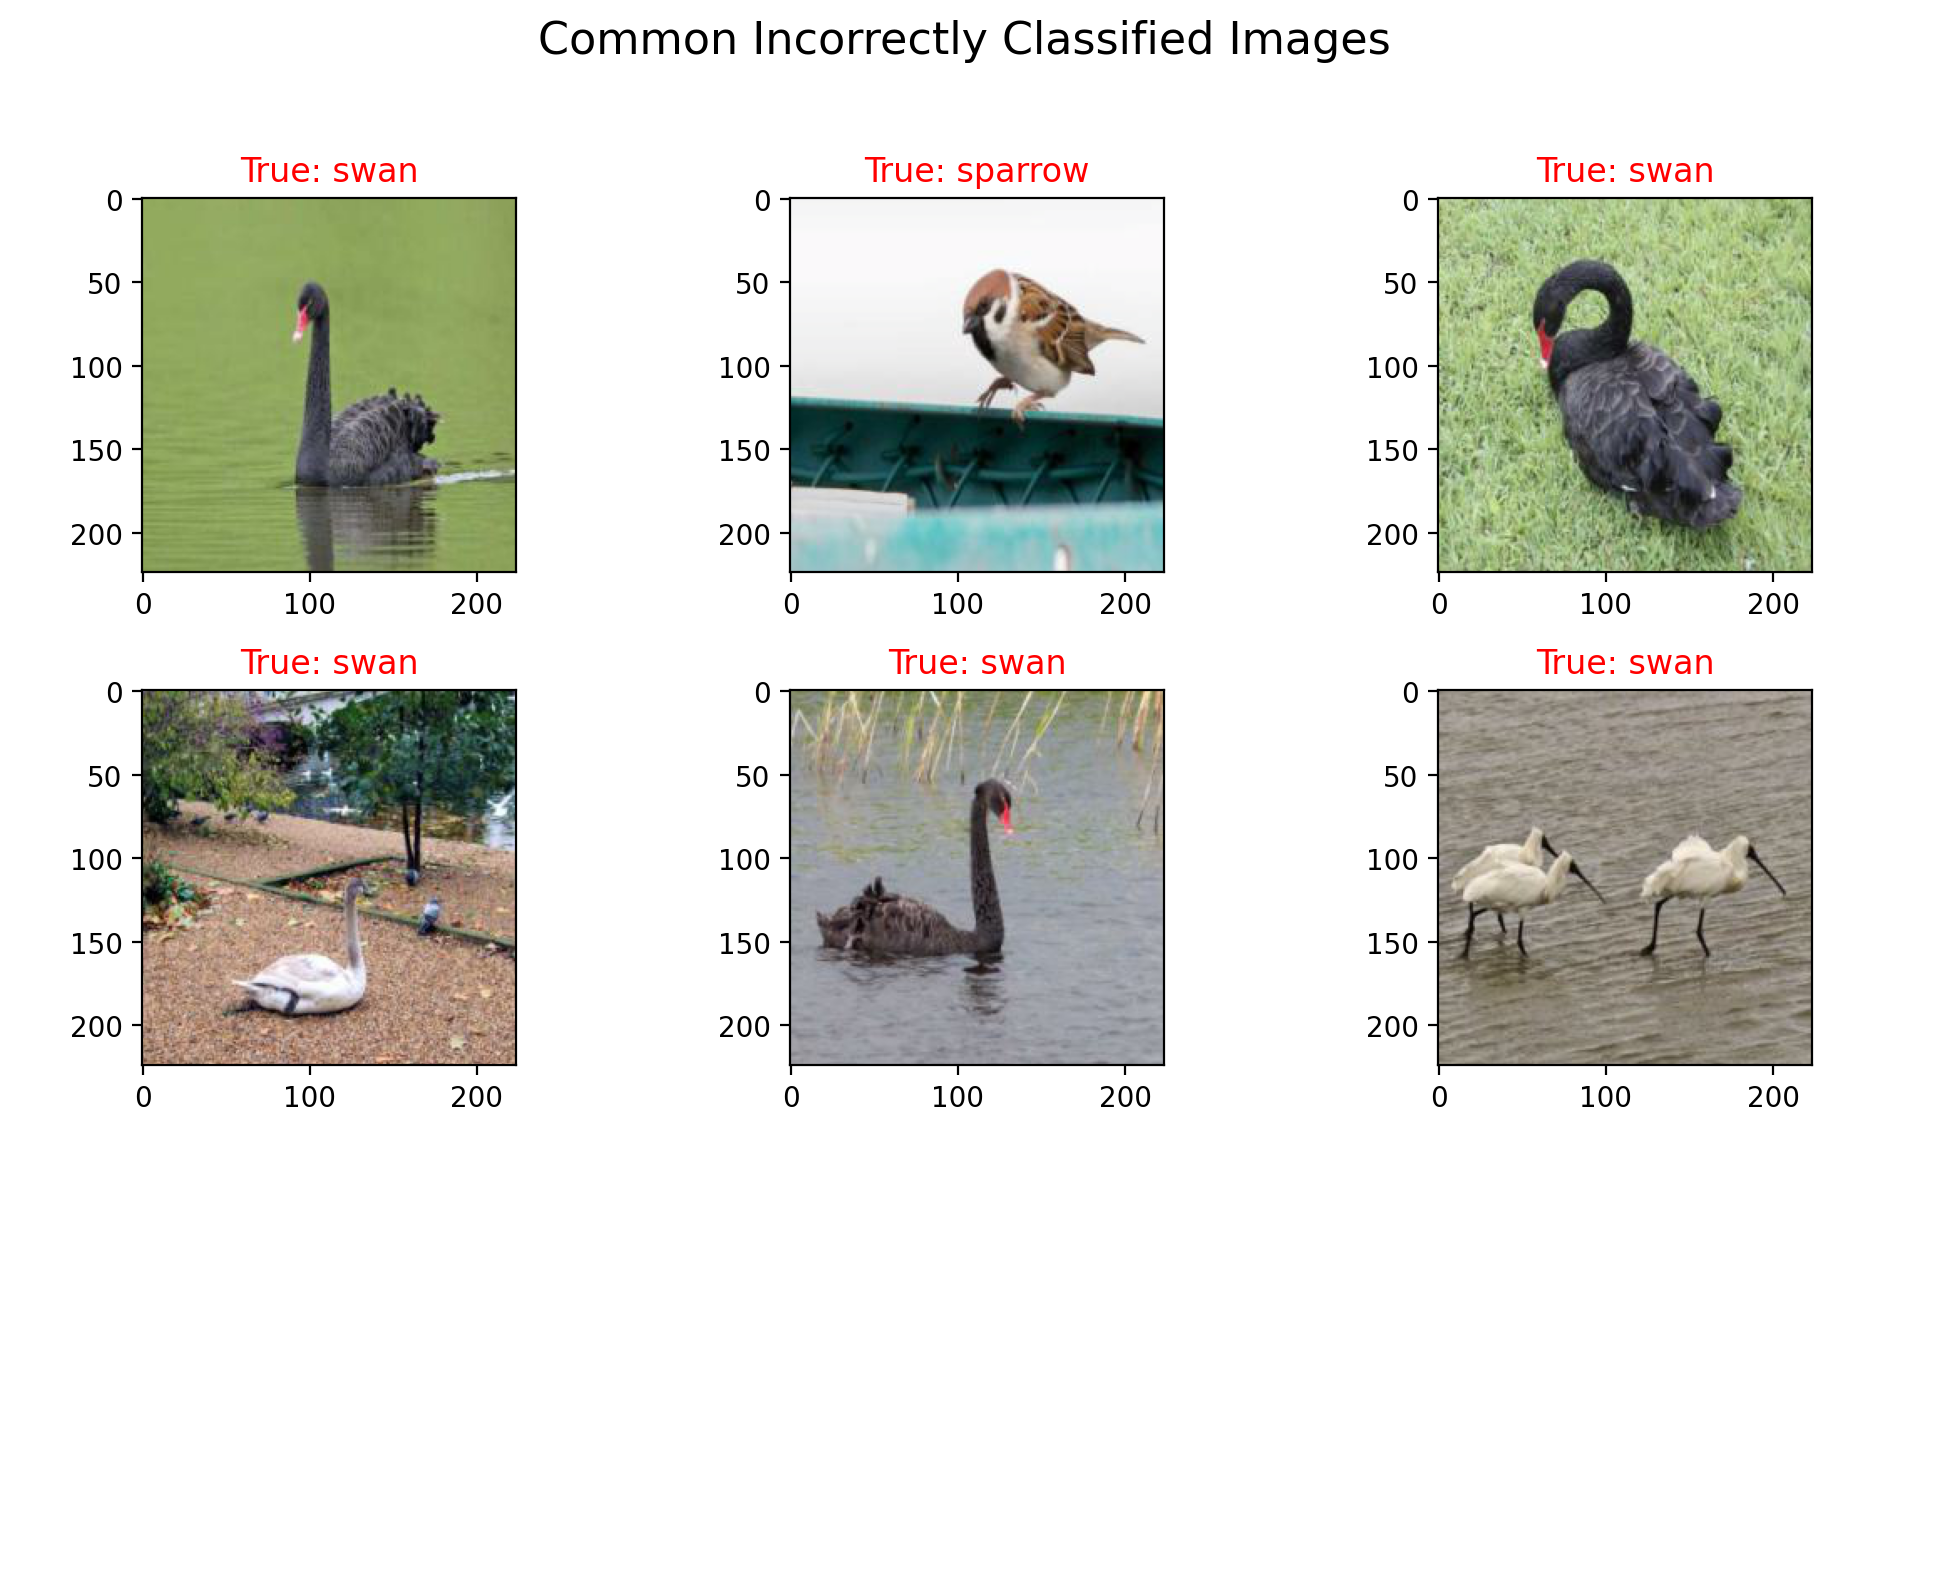

In [40]:
# plot the common indices
fig = plot_images(common_indices, test_loader, grid_size=(3,3), device='cuda' if torch.cuda.is_available() else 'cpu')
plt.show()

### Load models

In [30]:
# load the models from directory

model_1block = VGG1Block()
model_1block.load_state_dict(torch.load('models/model_VGG1Block.pth'))
model_1block.eval()

# display model weights and parameters
for name, param in model_1block.named_parameters():
    print(name, param.shape)


block_1.0.weight torch.Size([32, 3, 3, 3])
block_1.0.bias torch.Size([32])
fc_block.1.weight torch.Size([128, 401408])
fc_block.1.bias torch.Size([128])
fc_block.3.weight torch.Size([1, 128])
fc_block.3.bias torch.Size([1])


In [31]:
# load the models from directory

model_3block = VGG3Block()
model_3block.load_state_dict(torch.load('models/model_VGG3Block.pth'))
model_3block.eval()

# display model weights and parameters
for name, param in model_3block.named_parameters():
    print(name, param.shape)


block1.0.weight torch.Size([32, 3, 3, 3])
block1.0.bias torch.Size([32])
block2.0.weight torch.Size([64, 32, 3, 3])
block2.0.bias torch.Size([64])
block3.0.weight torch.Size([128, 64, 3, 3])
block3.0.bias torch.Size([128])
fc1.weight torch.Size([128, 100352])
fc1.bias torch.Size([128])
fc2.weight torch.Size([1, 128])
fc2.bias torch.Size([1])


#### Load generated_images